### Imports

In [22]:
%load_ext autoreload
%autoreload 2
from convnet import ConvDipNet
from timeDistributed import TimeDistributed
from torchinfo import summary
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch
import sys; sys.path.insert(0, '../')
from esinet.forward import create_forward_model, get_info
from esinet import Simulation
from copy import deepcopy
from CNN_LSTM.util import *
from dipoleDataset import DipoleDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Model Definition

In [23]:
# define hyperparameters
in_channels = 1
im_shape = (7,7)
n_filters = 8
kernel_size = (3,3)

# create single input ConvDipNet 
convnet: nn.Module  = ConvDipNet(in_channels, im_shape, n_filters, kernel_size)

# create TimeDistributed ConvDipNet to process all samples of timeseries at once
time_distributed_convnet: nn.Module = TimeDistributed(convnet, batch_first=True) # change batch_first to False for now for evaluation, will change back later

# print model summary
summary(time_distributed_convnet, input_size=(32, 100, 1, im_shape[0], im_shape[1])) # (batch_size, n_timesteps, in_channels, height, width)

Layer (type:depth-idx)                   Output Shape              Param #
TimeDistributed                          [32, 100, 5124]           --
├─ConvDipNet: 1-1                        [3200, 5124]              --
│    └─Conv2d: 2-1                       [3200, 8, 7, 7]           80
│    └─BatchNorm2d: 2-2                  [3200, 8, 7, 7]           16
│    └─Linear: 2-3                       [3200, 512]               201,216
│    └─BatchNorm1d: 2-4                  [3200, 512]               1,024
│    └─Linear: 2-5                       [3200, 5124]              2,628,612
Total params: 2,830,948
Trainable params: 2,830,948
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 9.07
Input size (MB): 0.63
Forward/backward pass size (MB): 177.46
Params size (MB): 11.32
Estimated Total Size (MB): 189.41

### Create forward model for simulations

In [24]:
# create forward model
fs = 100
info = get_info(sfreq=fs)
fwd = create_forward_model(sampling='ico4', info=info)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  14 | elapsed:    1.0s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:    1.1s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  10 out of  14 | elapsed:    1.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  14 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  10 out of  14 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  14 | elapsed:    0.7s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:    0.7

0 files missing from root.txt in /Users/zacariabalkhy/mne_data/MNE-sample-data/subjects
0 files missing from bem.txt in /Users/zacariabalkhy/mne_data/MNE-sample-data/subjects/fsaverage
Using surface: /Users/zacariabalkhy/mne_data/MNE-sample-data/subjects/fsaverage/bem/inner_skull.surf
Using surface: /Users/zacariabalkhy/mne_data/MNE-sample-data/subjects/fsaverage/bem/outer_skull.surf
Using surface: /Users/zacariabalkhy/mne_data/MNE-sample-data/subjects/fsaverage/bem/outer_skin.surf


/Users/zacariabalkhy/UCDAVIS_COURSES/MAE298/final_project/esinet_MAE298/venv/lib/python3.12/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


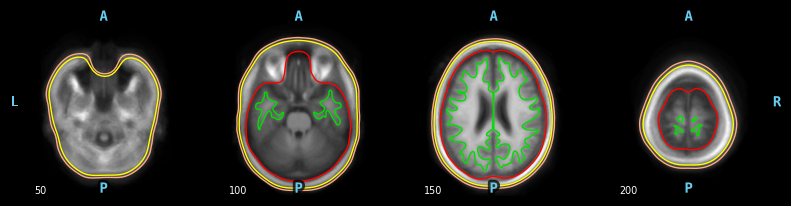

In [25]:
# plot BEM
import mne
import os
fs_dir = mne.datasets.fetch_fsaverage(verbose=True)
subjects_dir = os.path.dirname(fs_dir)
plot_bem_kwargs = dict(
    subject='fsaverage',
    subjects_dir=subjects_dir,
    brain_surfaces="white",
    orientation="axial", # axial for top down, coronal for front, sagittal for side
    slices=[50, 100, 150, 200],
)
mne.viz.plot_bem(**plot_bem_kwargs)


### Run simulations to create train/test/validation data

In [26]:
# define simulation settings
n_samples = 100
settings = dict(number_of_sources=(1, 5), extents=(21, 58)) # settings from paper

# create simulation data using forward model
sim = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)

Simulating data based on sparse patches.


100%|██████████| 100/100 [00:01<00:00, 60.39it/s]


In [62]:
sim.pos.shape

(5124, 3)

In [27]:
# extract eeg and source data as numpy arrays
eeg_data = np.array([sim.eeg_data[i].get_data(copy=False).squeeze() for i in range(len(sim.eeg_data))]) 
source_data = np.array([sim.source_data[i].data for i in range(len(sim.source_data))])

### Rescale and interpolate data

In [28]:
x_scaled = scale_eeg(eeg_data)
y_scaled  = scale_source(source_data)
x_scaled = [np.swapaxes(x,0,1) for x in eeg_data]
y_scaled = [np.swapaxes(y,0,1) for y in source_data]

print(len(x_scaled), x_scaled[0].shape)  # should be (n_samples, n_timesteps, n_channels)
print(len(y_scaled), y_scaled[0].shape)  # should be (n_samples, n_timesteps, n_dipoles)

100 (100, 61)
100 (100, 5124)


In [29]:
info = sim.eeg_data[0].info
x_scaled = interpolate_eeg(x_scaled, im_shape, info)

print(len(x_scaled), x_scaled[0].shape)  # should be (n_samples, n_timesteps, n_channels, im_height, im_width)

100 (100, 1, 7, 7)


### Split and batch data with a Dataloader

In [30]:
dataset = DipoleDataset(x_scaled, y_scaled, im_shape=im_shape)
test_size = 0.15
val_size = 0.15

test_amount, val_amount = int(dataset.__len__() * test_size), int(dataset.__len__() * val_size)

# this function will automatically randomly split your dataset but you could also implement the split yourself
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [
            (dataset.__len__() - (test_amount + val_amount)), 
            test_amount, 
            val_amount
])

In [31]:
B = 1  # batch size
train_dataloader = torch.utils.data.DataLoader(
            train_set,
            batch_size=B,
            shuffle=True,
)
val_dataloader = torch.utils.data.DataLoader(
            val_set,
            batch_size=B,
            shuffle=True,
)
test_dataloader = torch.utils.data.DataLoader(
            test_set,
            batch_size=B,
            shuffle=True,
)

### Train Loop

In [32]:
criterion = nn.CrossEntropyLoss()
lr = 0.001
betas=(0.9, 0.999)
eps = 1e-8
optimizer = optim.Adam(time_distributed_convnet.parameters(), lr=lr, 
                       betas=betas, eps=eps)

loss_values = []
for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    i = 0
    for sample, target in train_dataloader:

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = time_distributed_convnet(sample)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.8e}')
        i += 1
    loss_values.append(running_loss)

print('Finished Training')

Finished Training


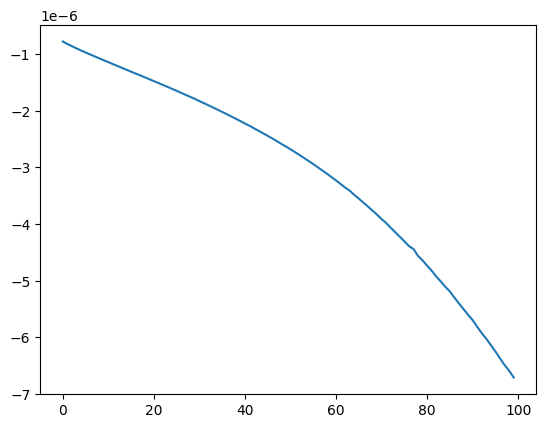

In [34]:
from matplotlib import pyplot as plt
plt.plot(np.array(loss_values))
plt.show()

### Evaluate AUC, MSE, nMSE, MLE

In [ ]:
from esinet.evaluate import eval_auc, eval_nmse, eval_mse, eval_mean_localization_error
pos = sim.pos
print(pos.shape)
with torch.no_grad():
    all_auc = []
    all_mse = []
    all_nmse = []
    all_mle = []
    for sample, target in val_dataloader:
        output = time_distributed_convnet(sample)
        
        # reshape to remove extra dimension
        target = target.view(100,5124)
        output = output.view(100,5124)
        sample_auc = 0
        sample_mle = 0
        sample_mse = 0
        sample_nmse = 0
        num_timesteps = target.shape[0]
        for ts in range(num_timesteps):
            target_ts = np.array(target[ts, :])
            output_ts = np.array(output[ts,:])
            
            auc_close, auc_far = eval_auc(target_ts, output_ts, pos)
            sample_auc += auc_close + auc_far
            
            mle = eval_mean_localization_error(target_ts, output_ts, pos)
            mse = eval_mse(target_ts, output_ts)
            nmse = eval_nmse(target_ts, output_ts)

        sample_auc = sample_auc/(2*num_timesteps)
        sample_mle = sample_mle/num_timesteps
        sample_mse = sample_mse/num_timesteps
        sample_nmse = sample_nmse/num_timesteps
        all_auc.append(sample_auc)
        all_mle.append(sample_mle)
        all_mse.append(sample_mse)
        all_nmse.append(sample_nmse)


(5124, 3)
